# Imports

In [1]:
# Import necessary libraries for mathematical operations and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

# Import astropy modules for working with astronomical data
import astropy.units as u
from astropy.visualization import simple_norm, SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import angular_separation, Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy.nddata import Cutout2D
# Import os for directory operations
import os
# Import astroalign for aligning astronomical images
import astroalign as align
# Import twirl for peak finding and WCS (World Coordinate System) computations
from twirl import find_peaks
from twirl import gaia_radecs
from twirl.geometry import sparsify
from twirl import compute_wcs
# Import photutils for aperture photometry
from photutils.aperture import SkyCircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from pylab import figure, cm
# Import pandas for data manipulation
import pandas as pd

import random

In [2]:
#Constnats
# BLUE_FILTER_COLOR =  'Blues'
# RED_FILTER_COLOR =  'Reds'

BLUE_FILTER_COLOR =  cm.grey
RED_FILTER_COLOR =  cm.grey

# Target

In [4]:
DIRECTORY="m2/"
# DIRECTORY="m13/"

# Gather all the files

In [ ]:
#Get the file directory
darks_directory     = DIRECTORY + "darks/120/"
bias_directory      = DIRECTORY + "bias/2x2/"

Detected 13 dark images
Detected 65 bias images
Detected 15 Blue Filter images from Nov 2nd 2024
Detected 15 Red Filter images from Nov 2nd 2024
Detected 15 Blue Filter images from Nov 5th 2024
Detected 15 Red Filter images from Nov 5th 2024


# Get the co-orditane of M2 stars and their brightness from Database
#### used CANFAR's Stetson Database

In [22]:
# load the data from memory
coords = pd.read_csv( DIRECTORY + "NGC7089.pos", sep='[ ]{2,}', engine='python') # replace anything w 2 or more spaces with just a space
mags = pd.read_csv(DIRECTORY + "NGC7089.pho", sep='[ ]{1,}', engine='python') # replace anything w 1 or more spaces with just a space



# Let's extract what we need from the stetson database

In [23]:
# add coloum names to the coordinate file
coords.rename(columns={'323.36209232807' : 'RA', '-00.84555554920' : 'DEC'}, inplace=True) # replace the orgonal col names for somethig meaningfull

# Convert the DEC column to string type first
coords['DEC'] = coords['DEC'].astype(str)

# Now you can use the .str accessor to replace spaces
coords['DEC'] = coords['DEC'].str.replace(" ", "")

# Convert the DEC column back to float type
coords['DEC'] = coords['DEC'].astype(float)

# Perform the merge with the photometry data
stetson = pd.merge(coords[["Reference", 'RA', 'DEC']], mags[["Reference", 'B', 'sigma.1', 'R', 'sigma.3']], how='inner', on=['Reference'])

# Filter the stars with magnitude of 18 or brighter
stetson = stetson[(stetson.B < 19) & (stetson.R < 19)]

stetson_b_filter = stetson[["Reference", 'RA', 'DEC', 'B', 'sigma.1']]
stetson_r_filter = stetson[["Reference", 'RA', 'DEC', 'R', 'sigma.3']]


# Lets plot what we extracted

In [ ]:
stetson_pos_b_filter = np.array(wcs_b_filter.world_to_pixel_values( stetson_b_filter[["RA", "DEC"]] ))
stetson_pos_r_filter = np.array(wcs_r_filter.world_to_pixel_values( stetson_r_filter[["RA", "DEC"]] ))

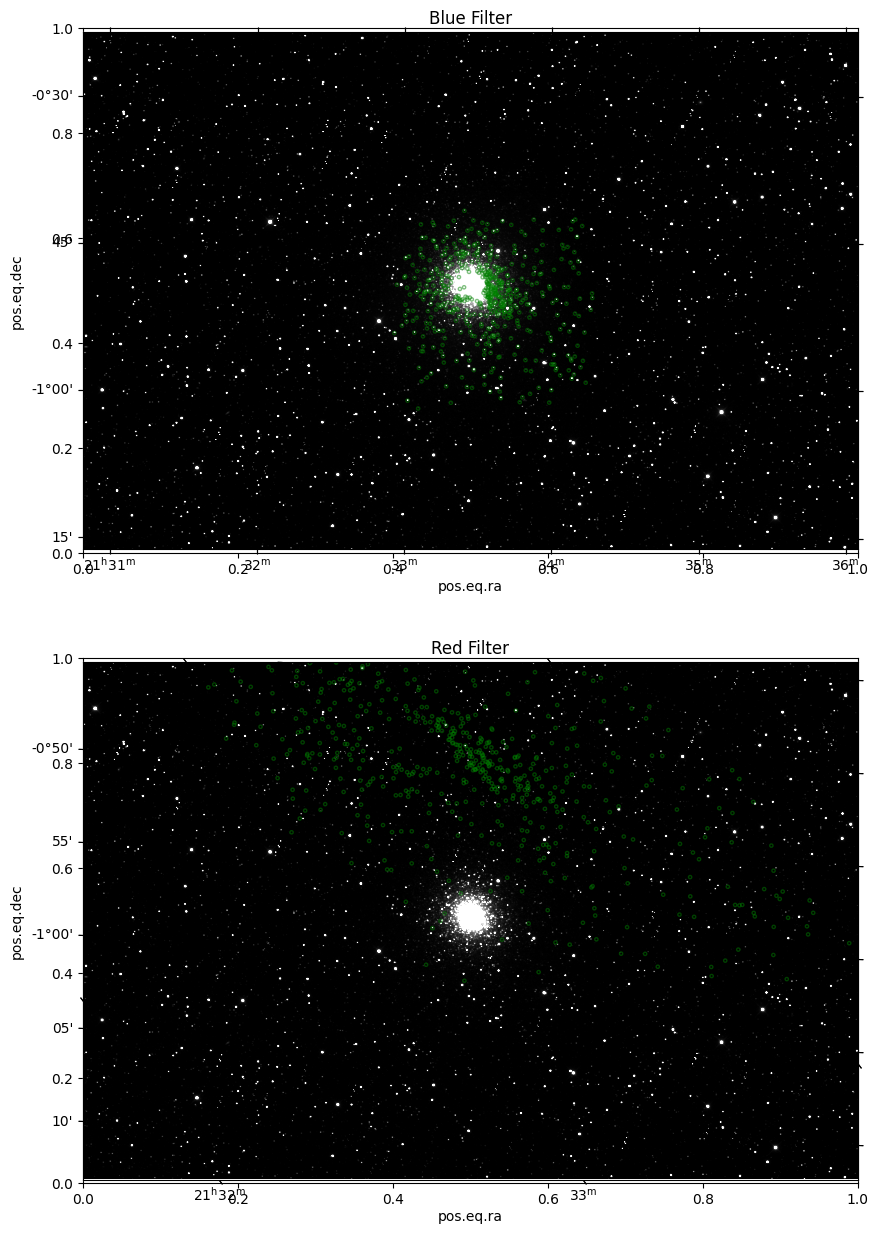

<Figure size 640x480 with 0 Axes>

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# Blue filter plot
ax1 = plt.subplot(2, 1, 1, projection = wcs_b_filter)
ax1.imshow(b_filter_fits.data, vmin = np.median(b_filter_fits.data), vmax = 3 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
_ = CircularAperture(stetson_pos_b_filter, 10).plot(color = "g", alpha = 0.5)
ax1.set_title('Blue Filter')

# Blue filter plot
ax2 = plt.subplot(2, 1, 2, projection = wcs_r_filter)
ax2.imshow(r_filter_fits.data, vmin = np.median(r_filter_fits.data), vmax = 3 * np.median(r_filter_fits.data), cmap = RED_FILTER_COLOR)
_ = CircularAperture(stetson_pos_r_filter, 10).plot(color = "g", alpha = 0.5)
ax2.set_title('Red Filter')


plt.show()
plt.savefig(DIRECTORY + "Steton Catalog Stars.jpg")
plt.clf()

# Lets define & Work with a small subsection
#### FOV too large

In [26]:
position = (2200, 1000)
size = (1000, 1000)
cutout_b_filter = Cutout2D(b_filter_fits.data, position, size, wcs = wcs_b_filter)
cutout_r_filter = Cutout2D(r_filter_fits.data, position, size, wcs = wcs_r_filter)


In [27]:
#make 2 empyth fits files
b_filter_analysis = fits.PrimaryHDU()
r_filter_analysis = fits.PrimaryHDU()

#point them to the cutout data
b_filter_analysis.data = cutout_b_filter.data
r_filter_analysis.data = cutout_r_filter.data

b_filter_analysis.header.update(cutout_b_filter.wcs.to_header())
r_filter_analysis.header.update(cutout_r_filter.wcs.to_header())


In [28]:
#compute wcs for this cutout
peaks_b_filter = find_peaks(b_filter_analysis.data)[0:20]
wcs_cutout_b_filter = compute_wcs(peaks_b_filter, all_radecs_b_filter[0:30], tolerance = 10)
stetson_pos_b_filter = np.array(wcs_cutout_b_filter.world_to_pixel_values(stetson[["RA", "DEC"]]))


peaks_r_filter = find_peaks(r_filter_analysis.data)[0:20]
wcs_cutout_r_filter = compute_wcs(peaks_r_filter, all_radecs_r_filter[0:30], tolerance = 10)
stetson_pos_r_filter = np.array(wcs_cutout_r_filter.world_to_pixel_values(stetson[["RA", "DEC"]]))


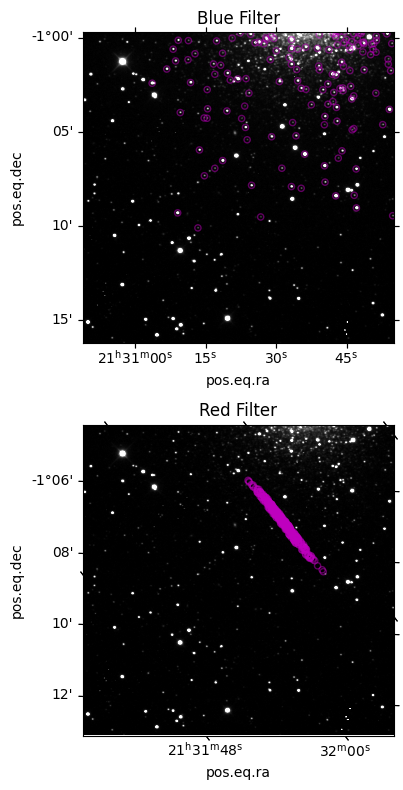

<Figure size 640x480 with 0 Axes>

In [29]:
# Create a new figure
fig = plt.figure(figsize=(10, 8))

# Blue filter plot on top
ax1 = fig.add_subplot(2, 1, 1, projection = wcs_b_filter)
ax1.imshow(b_filter_analysis.data, vmin=np.median(b_filter_fits.data), vmax=3 * np.median(b_filter_fits.data), cmap="Greys_r")
CircularAperture(stetson_pos_b_filter, 10).plot(ax=ax1, color="m", alpha=0.5)
ax1.set_title('Blue Filter')

# Red filter plot on bottom
ax2 = fig.add_subplot(2, 1, 2, projection = wcs_r_filter)
ax2.imshow(r_filter_analysis.data, vmin=np.median(r_filter_fits.data), vmax=3 * np.median(r_filter_fits.data), cmap="Greys_r")
CircularAperture(stetson_pos_r_filter, 10).plot(ax=ax2, color="m", alpha=0.5)
ax2.set_title('Red Filter')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
plt.savefig(DIRECTORY + "TWIRL peaks in curout.jpg")
